Experiment outline:

We want to run an experiment comparing tune-pruning with training from scratch. We'll need to do the following experiments:
1) Train a general model across all tasks
2) Perform prune-tuning on the general model to distill it on the compositional subtask
3) Train models from scratch on the compositional subtask, of varying size.

For step (2), the default approach would be to do what Asher did and take multiple checkpoints during a single tune-pruning run. So periodically during training, we prune the network as aggressively as we can while ensuring that ~100% test accuracy is preserved.

For step (3), we'll just need a script that trains models from scratch on only the compositional subtask.

For these experiments, I think I'll use atomic subtasks with k=3, and then the compositional subtasks will be composed from 3 atomic subtasks, for an effective k=9. I hope this will still be learnable by the models from scratch in reasonable time.


**This notebook implements step (2)**. We will load up the general model and perform prune-tuning on the compositional subtask.

In [1]:
import os
import copy
import pickle
from collections import defaultdict, OrderedDict

import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from nnsight import NNsight

from general.train import (
    depth, width, activation_fn,
    n_tasks, n, Ss, codes,
    get_batch, construct_mlp
)

In [2]:
def visualize_mlp(model, weight_threshold=0.3, color_range=[-1, 1]):
    assert isinstance(model, nn.Sequential), "Model must be nn.Sequential"
    layers = [module for module in model if isinstance(module, nn.Linear)]
    
    fig, ax = plt.subplots(figsize=(12, 8))
    max_width = max(
        max(layer.in_features, layer.out_features) for layer in layers
    )
    ax.set_xlim(-max_width*0.05, max_width*1.05)
    ax.set_ylim(-0.2, len(layers)+0.2)

    positions = list()
    for i, layer in enumerate(layers):
        pos = np.linspace(0, max_width-1, layer.in_features)
        positions.append(pos)
    positions.append(np.linspace(0, max_width-1, layer.out_features))

    # plot the neurons (with high zorder to be on top of connections)
    for i, layer in enumerate(layers):
        ax.scatter(positions[i], [i] * layer.in_features, s=10, c='black', zorder=10)
    ax.scatter(positions[-1], [len(layers)] * layer.out_features, s=10, c='black', zorder=10)

    # plot the connections
    for i, layer in enumerate(layers):
        weights = layer.weight.detach().cpu().numpy()
        for j in range(layer.in_features):
            for k in range(layer.out_features):
                weight = weights[k, j]
                if abs(weight) > weight_threshold:
                    color = plt.cm.bwr((weight - color_range[0]) / (color_range[1] - color_range[0]))
                    ax.plot([positions[i][j], positions[i+1][k]], [i, i+1], 
                            c=color, 
                            linewidth=abs(weight) * 2, 
                            alpha=0.7)

    ax.axis("off")


In [3]:
# @torch.no_grad()
# def total_effects_neurons(mlp_n, x, y, loss_fn, activation_fn=nn.ReLU):
#     """Compute the effect -- change in loss -- of ablating each hidden layer neuron.
#     Ablation is performed by setting the post-activation outputs to zero. It
#     is assumed that the network is simply alternating nn.Linear and activation
#     function layers with the naming scheme 'fc{i}' and 'act{i}' following it.
    
#     Parameters
#     ----------
#     mlp_n : NNsight
#         Neural network to analyze, wrapped in NNsight.
#     x : torch.Tensor
#         Batch of inputs.
#     y : torch.Tensor
#         Batch of labels.
#     loss_fn
#         Loss function.
    
#     Returns
#     -------
#     Dictionary mapping layers (e.g. 'act0') to a list of floats.
#     """
#     baseline_loss = loss_fn(mlp_n.forward(x), y).item()
#     effects = defaultdict(list)
#     hiddenact_names = [name for name, module in mlp.named_children() if isinstance(module, activation_fn)]
#     for actname in hiddenact_names:
#         width = getattr(mlp, actname.replace("act", "fc")).out_features
#         for neuroni in range(width):
#             with mlp_n.trace(x):
#                 getattr(mlp_n, actname).output[:, neuroni] = 0.0
#                 y_pred = mlp_n.output.save()
#             effects[actname].append(loss_fn(y_pred, y).item() - baseline_loss)
#     return effects

In [4]:
# def prune_mlp(mlp_n, x, y, loss_fn, effects, threshold=1e-2):
#     """Prune as many neurons as possible from the MLP while keeping loss below threshold.
    
#     Parameters
#     ----------
#     mlp_n : torch.nn.Module
#         Multi-layer perceptron, wrapped in NNsight.
#     effects : dict
#         Dictionary mapping layers (e.g. 'act0') to a list of floats.
#     threshold : float
#         Threshold for pruning.
#     Returns
#     -------
#     statistics of how many neurons can be pruned
#     """
#     stats = {
#         "total_kept": 0,
#         "total_removed": 0,
#     }
    
#     # organize all neurons into a list:
#     all_neurons = [(actname, i, effect[i]) for actname, effect in effects.items() for i in range(len(effect))]
#     for actname in effects.keys():
#         for i in range(len(effects[actname])):
#             all_neurons.append((actname, i, effects[actname][i]))
#     print(all_neurons)
#     all_neurons = sorted(all_neurons, key=lambda x: x[2]) # least effect to greatest

#     # remove neurons one by one
#     losses = []
#     pruned_neurons = []
#     neuroni = 0
#     for actname, i, effect in all_neurons:
#         pruned_neurons.append((actname, i))
#         neuroni += 1
#         with mlp_n.trace(x):
#             for actname, i in pruned_neurons:
#                 getattr(mlp_n, actname).output[:, i] = 0.0
#             y_pred = mlp_n.output.save()
#         losses.append(loss_fn(y_pred, y).item())
#         if losses[-1] > threshold:
#             neuroni -= 1
#             pruned_neurons.pop()
#             break
#     stats["total_removed"] = neuroni
#     stats["total_kept"] = len(all_neurons) - neuroni

#     return stats

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
dtype = torch.float32
torch.set_default_dtype(dtype)

Using device: cuda


In [6]:
mlp = construct_mlp(
    [n_tasks + n] + [width] * (depth - 1) + [2], 
    activation_fn
).to(dtype).to(device)

mlp.load_state_dict(torch.load("general/model_final.pt"))

<All keys matched successfully>

In [7]:
def prunability(mlp, x, y, loss_fn, effect_thresholds=[1e-10, 1e-8, 1e-6, 1e-4, 1e-2], loss_threshold=1e-2):
    """ Computes the number of neurons that can be pruned from the MLP while 
    keeping the loss below a certain threshold on the given dataset.

    This function first estimates the effects of ablating each neuron with
    attribution patching. Then we prune neurons with effect below varying 
    thresholds and recompute the loss, checking that it remains below the
    `loss_threshold`.
    """
    mlp_n = NNsight(mlp)
    effect_thresholds = sorted(effect_thresholds)
    layer_names = [name for name, module in mlp.named_children() if name.startswith("act")]

    # compute effects
    with mlp_n.trace(x):
        activations = {}
        grads = {}
        for name in layer_names:
            activations[name] = getattr(mlp_n, name).output.save()
            grads[name] = getattr(mlp_n, name).output.grad.save()
        y_pred = mlp_n.output
        loss = loss_fn(y_pred, y)
        loss.backward()
    effects = {}
    for name in layer_names:
        effects[name] = torch.mean(activations[name] * grads[name], dim=0)
    
    # prune neurons and check loss
    pruning_results = {}
    for threshold in effect_thresholds:
        with mlp_n.trace(x):
            for name in layer_names:
                getattr(mlp_n, name).output[:, effects[name].abs() < threshold] = 0.0
            y_pred = mlp_n.output.save()
        loss = loss_fn(y_pred, y).item()
        if loss > loss_threshold:
            break
        pruning_results[threshold] = {
            "loss": loss,
            "neurons_kept": {
                name: (effects[name].abs() >= threshold).nonzero().flatten().tolist()
                for name in layer_names
            }
        }
    
    # free memory
    del mlp_n
    del activations
    del grads
    del y_pred
    del effects

    if not pruning_results:
        return {
           "loss": loss_fn(mlp.forward(x), y).item(),
              "neurons_kept": {
                name: list(range(getattr(mlp, name.replace("act", "fc")).out_features))
                for name in layer_names
              } 
        }
    # last acceptable threshold
    last_threshold = max(pruning_results.keys())
    return pruning_results[last_threshold]


In [8]:
# x, y = get_batch(n_tasks, n, Ss, [[0, 1, 2]], [10_000], device=device, dtype=dtype)

# results = prunability(
#     mlp,
#     x, y,
#     nn.CrossEntropyLoss(),
#     effect_thresholds=[1e-10, 1e-8, 1e-6, 1e-4, 1e-2],
#     loss_threshold=1e-2
# )

In [9]:
# len(results['neurons_kept']['act0'])

In [10]:
# results

In [11]:
# x, y = get_batch(n_tasks, n, Ss, [[0, 1, 2]], [10_000], device=device, dtype=dtype)
# effects = total_effects_neurons(
#     NNsight(mlp), 
#     x, y,
#     nn.CrossEntropyLoss(),
# )

In [12]:
# stats = prune_mlp(
#     NNsight(mlp), 
#     x, y,
#     nn.CrossEntropyLoss(),
#     effects,
#     threshold=1e-2
# )

In [13]:
# mlp_n = NNsight(mlp)

In [14]:
# x, y = get_batch(n_tasks, n, Ss, [[0, 1, 2]], [10_000], device=device, dtype=dtype)

In [15]:
# mlp_n

In [16]:
# with mlp_n.trace(x):
#     act0 = mlp_n.act0.output.save()
#     act0_grads = mlp_n.act0.output.grad.save()
#     y_pred = mlp_n.output
#     loss = nn.CrossEntropyLoss()(y_pred, y)
#     loss.backward()


In [17]:
# act0_effects = torch.mean(act0 * act0_grads, dim=0)

In [18]:
# act0_effects.abs().min()

In [19]:
LAMBDA = 3e-4

optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3, eps=1e-5)
loss_fn = nn.CrossEntropyLoss()

steps = []
losses = []
pred_losses = []
sparsity_losses = []
remaining_neurons = []
# subtask_losses = defaultdict(list)
for step in tqdm(range(10_000)):
    # with torch.no_grad():
    #     for i, code in enumerate(codes):
    #         x, y = get_batch(n_tasks, n, Ss, [code], [train_sizes[i]], device=device, dtype=dtype)
    #         y_pred = mlp(x)
    #         subtask_losses[i].append(loss_fn(y_pred, y).item())
    x, y = get_batch(n_tasks, n, Ss, [[0, 1, 2]], [10_000], device=device, dtype=dtype)
    y_pred = mlp(x)
    pred_loss = loss_fn(y_pred, y)
    sparsity_loss = 0
    for p in mlp.parameters():
        sparsity_loss += torch.sum(p.abs())
    loss = pred_loss + LAMBDA * sparsity_loss 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    steps.append(step)
    losses.append(loss.item())
    pred_losses.append(pred_loss.item())
    sparsity_losses.append(sparsity_loss.item())

    if step % 30 == 0:
        # get pruning results
        prunability_results = prunability(
            mlp,
            x, y,
            loss_fn,
            effect_thresholds=[1e-10, 1e-8, 1e-6, 1e-4, 1e-2],
            loss_threshold=1e-2
        )
        n_remaining = sum(len(neurons) for neurons in prunability_results["neurons_kept"].values())
        remaining_neurons.append(n_remaining)

    if step % 30 == 0:
        # save a visualization of the model
        visualize_mlp(mlp, weight_threshold=0.3, color_range=[-1, 1])
        plt.title(f"Step {step}")
        plt.savefig(f"pruning/connectivities/pruning_step_{step:04d}.png")
        plt.close()
    
    if step % 30 == 0:
        # compute attribution effects for first layer
        mlp_n = NNsight(mlp)
        with mlp_n.trace(x):
            act0 = mlp_n.act0.output.save()
            act0_grads = mlp_n.act0.output.grad.save()
            act1 = mlp_n.act1.output.save()
            act1_grads = mlp_n.act1.output.grad.save()
            y_pred = mlp_n.output
            loss = nn.CrossEntropyLoss()(y_pred, y)
            loss.backward()
        act0_effects = torch.mean(act0 * act0_grads, dim=0)
        act1_effects = torch.mean(act1 * act1_grads, dim=0)
        hist0, bins0 = np.histogram(act0_effects.abs().detach().cpu().numpy(), bins=np.logspace(-16, 1, 50))
        hist1, bins1 = np.histogram(act1_effects.abs().detach().cpu().numpy(), bins=np.logspace(-16, 1, 50))
        plt.figure(figsize=(6, 4))
        plt.plot(bins0[:-1], hist0, label="Layer 1")
        plt.plot(bins1[:-1], hist1, label="Layer 2")
        plt.xscale("log")
        plt.yscale("log")
        plt.xlabel("Estimated effect of ablating neuron")
        plt.ylabel("Number of neurons")
        plt.legend()
        plt.title(f"Step {step}")
        plt.savefig(f"pruning/effects/pruning_step_{step:04d}.png")
        plt.close()
        

  0%|          | 0/10000 [00:00<?, ?it/s]

Text(0, 0.5, 'Total loss')

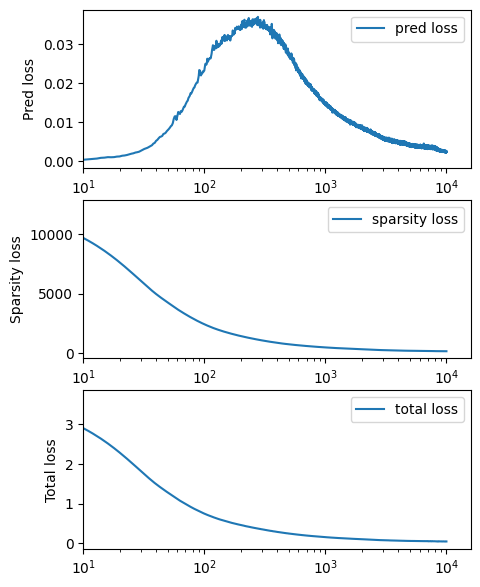

In [20]:
plt.figure(figsize=(5, 7))

plt.subplot(3, 1, 1)

plt.plot(steps, pred_losses, label="pred loss")
plt.legend()
plt.xscale('log')
plt.xlim(10, None)
plt.ylabel("Pred loss")

plt.subplot(3, 1, 2)
plt.plot(steps, sparsity_losses, label="sparsity loss")
plt.legend()
plt.xscale('log')
plt.xlim(10, None)
plt.ylabel("Sparsity loss")

plt.subplot(3, 1, 3)
plt.plot(steps, losses, label="total loss")
plt.legend()
plt.xscale('log')
plt.xlim(10, None)
plt.ylabel("Total loss")


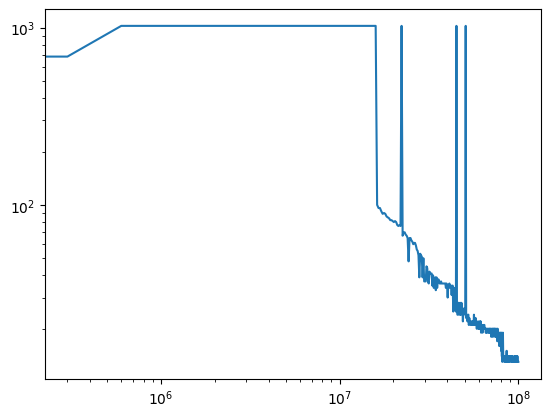

In [27]:
n_samples = list(range(0, 10_000 * len(steps), 10_000))
# plt.plot(remaining_neurons, n_samples[::30])
plt.plot(n_samples[::30], remaining_neurons)
plt.xscale('log')
plt.yscale('log')
# plt.xlabel("Number of hidden neurons in network")
# plt.ylabel("Number of samples used")

In [39]:
mlp_n = NNsight(mlp)
x, y = get_batch(n_tasks, n, Ss, [[0, 1, 2]], [10_000], device=device, dtype=dtype)

with mlp_n.trace(x):
    act0 = mlp_n.act0.output.save()
    act0_grads = mlp_n.act0.output.grad.save()
    y_pred = mlp_n.output
    loss = nn.CrossEntropyLoss()(y_pred, y)
    loss.backward()

act0_effects = torch.mean(act0 * act0_grads, dim=0)

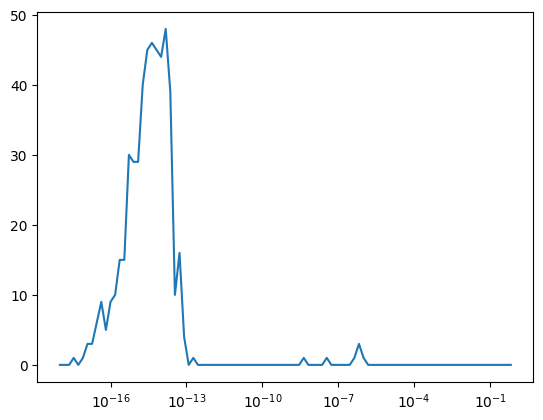

In [50]:
hist, bin_edges = np.histogram(act0_effects.abs().detach().cpu().numpy(), bins=np.logspace(-18, 0, 100))
plt.plot(bin_edges[:-1], hist, label="act0")
plt.xscale('log')

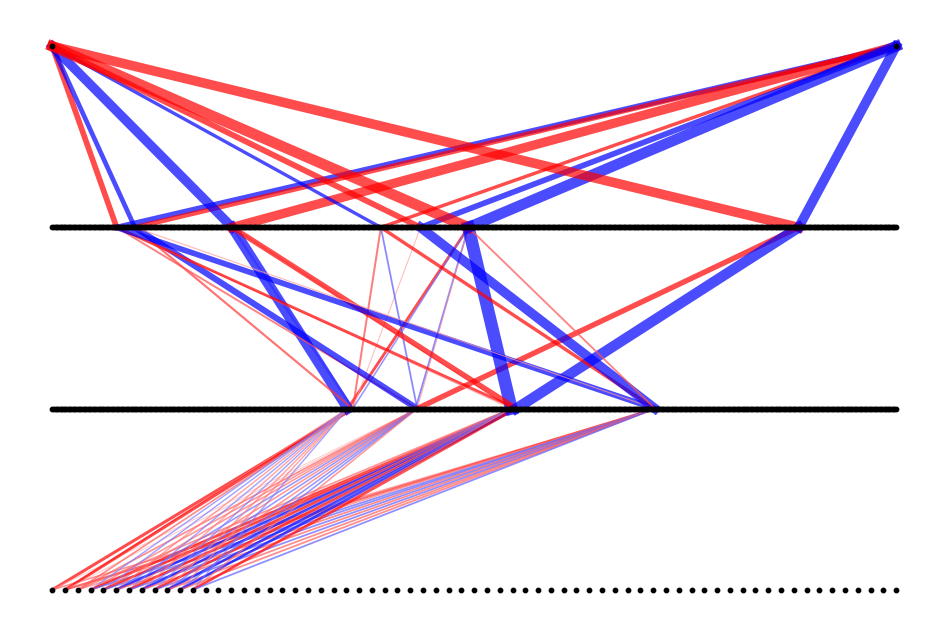

In [44]:
visualize_mlp(mlp)

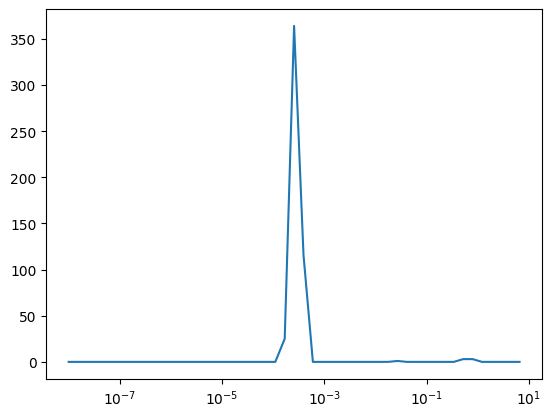

In [59]:
hist, bin_edges = np.histogram(mlp.fc0.weight.abs().max(dim=1).values.detach().cpu(), bins=np.logspace(-8, 1, 50))
plt.plot(bin_edges[:-1], hist, label="fc0")
plt.xscale('log')

In [67]:
(mlp.fc0.weight.abs().max(dim=1).values > 1e-1).nonzero()[:, 0].tolist()

[179, 182, 221, 278, 281, 365]

In [71]:
(act0_effects.abs() > 1e-8).nonzero()[:, 0].tolist()

[179, 182, 221, 278, 281, 365]